Epoch 1/20
6/6 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7374 - precision_2: 0.7801 - recall_2: 0.9237 - f1_score: 0.8458

C:\anapy\lib\site-packages\keras\src\engine\training.py:2620: UserWarning: Metric FBetaScore implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


6/6 [==============================] - 32s 5s/step - loss: 0.6794 - accuracy: 0.7374 - precision_2: 0.7801 - recall_2: 0.9237 - f1_score: 0.8458 - val_loss: 0.6663 - val_accuracy: 0.7828 - val_precision_2: 0.7828 - val_recall_2: 1.0000 - val_f1_score: 0.8782 - lr: 1.0000e-04
Epoch 2/20


C:\anapy\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


6/6 [==============================] - 28s 5s/step - loss: 0.6649 - accuracy: 0.7791 - precision_2: 0.7797 - recall_2: 0.9989 - f1_score: 0.8758 - val_loss: 0.6514 - val_accuracy: 0.7828 - val_precision_2: 0.7828 - val_recall_2: 1.0000 - val_f1_score: 0.8782 - lr: 1.0000e-04
Epoch 3/20
6/6 [==============================] - 29s 5s/step - loss: 0.6484 - accuracy: 0.7797 - precision_2: 0.7798 - recall_2: 1.0000 - f1_score: 0.8762 - val_loss: 0.6308 - val_accuracy: 0.7828 - val_precision_2: 0.7828 - val_recall_2: 1.0000 - val_f1_score: 0.8782 - lr: 1.0000e-04
Epoch 4/20
6/6 [==============================] - 28s 5s/step - loss: 0.6243 - accuracy: 0.7798 - precision_2: 0.7798 - recall_2: 1.0000 - f1_score: 0.8762 - val_loss: 0.6004 - val_accuracy: 0.7828 - val_precision_2: 0.7828 - val_recall_2: 1.0000 - val_f1_score: 0.8782 - lr: 1.0000e-04
Epoch 5/20
6/6 [==============================] - 29s 5s/step - loss: 0.5894 - accuracy: 0.7798 - precision_2: 0.7798 - recall_2: 1.0000 - f1_score: 0

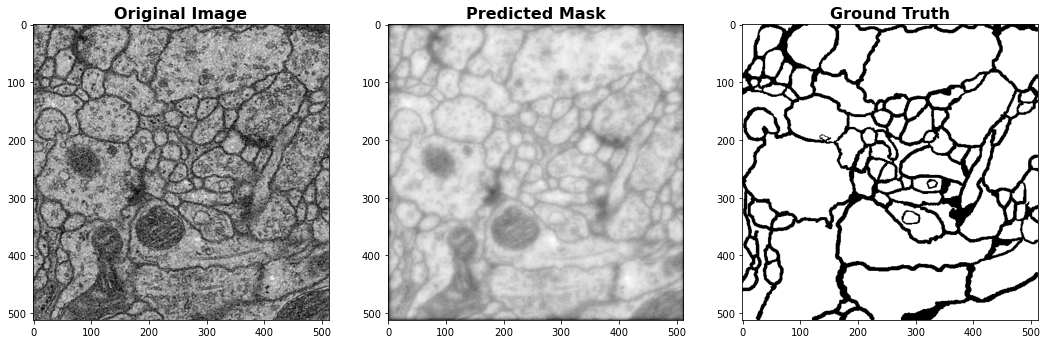

1/1 [==============================] - 1s 1s/step


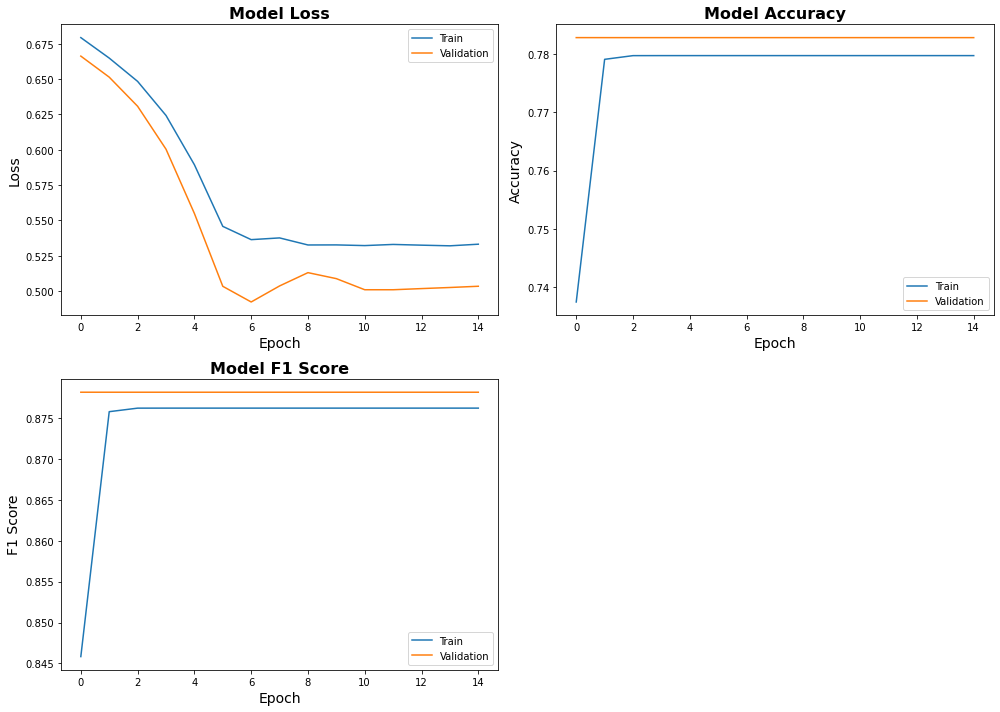

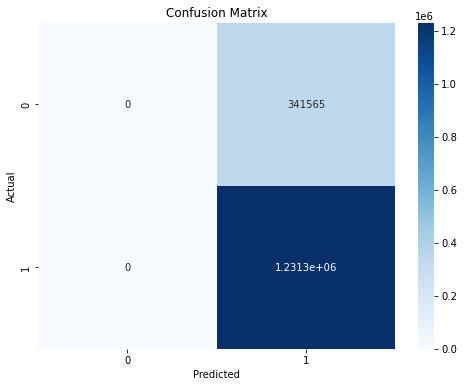

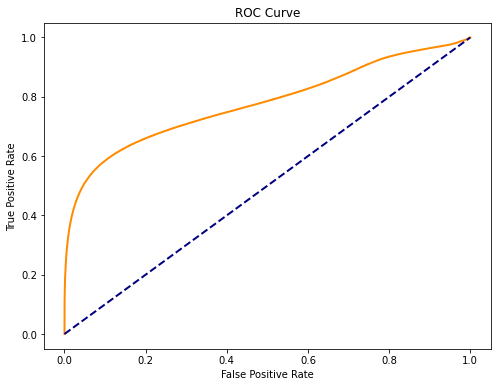

In [2]:

# Import necessary libraries
from PIL import Image
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns



# Define FBetaScore metric
class FBetaScore(tf.keras.metrics.Metric):
    def __init__(self, beta=1, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
        self.beta = beta

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.keras.backend.flatten(y_true)
        y_pred = tf.keras.backend.flatten(y_pred)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return (1 + self.beta**2) * (precision * recall) / ((self.beta**2 * precision) + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

    @property
    def precision_2(self):
        return self.precision.result()

# Define directory paths
train_images_dir = "C:/Users/Krishnna Nikhil/Downloads/train-volume-20231205T163419Z-001/train-volume/"
label_images_dir = "C:/Users/Krishnna Nikhil/Downloads/train-labels-20231205T163410Z-001/train-labels/"

# Define number of images
num_images = 30

# Load image files
train_files = [f"train-volume_{i}.tif" for i in range(num_images)]
label_files = [f"train-labels_{i}.tif" for i in range(num_images)]

# Define functions for loading and pre-processing images
def load_image(file_path):
    return np.array(Image.open(file_path))

def preprocess_images(image):
    return image / 255.0

# Load and pre-process images
train_images = [preprocess_images(load_image(os.path.join(train_images_dir, file))) for file in train_files]
label_images = [preprocess_images(load_image(os.path.join(label_images_dir, file))) for file in label_files]

# Add channel dimension for compatibility
train_images = np.array([np.expand_dims(img, axis=-1) for img in train_images])
label_images = np.array([np.expand_dims(img, axis=-1) for img in label_images])

# Get input shape with channel dimension
input_shape = train_images[0].shape

# Define U-Net model architecture, residual connections, and attention mechanisms
def unet_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.Dropout(0.2)(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.Dropout(0.2)(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    # Attention mechanism
    attention1 = layers.Conv2D(32, 1, activation='sigmoid')(pool1)
    attention2 = layers.Conv2D(64, 1, activation='sigmoid')(pool2)
    pool1 = layers.multiply([pool1, attention1])
    pool2 = layers.multiply([pool2, attention2])

    # Decoder
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.Dropout(0.2)(conv3)
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)

    # Residual connection
    up1 = layers.concatenate([up1, conv2])

    conv4 = layers.Conv2D(32, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.Dropout(0.2)(conv4)
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)

    up2 = layers.concatenate([up2, conv1])

    # Output layer
    output = layers.Conv2D(1, 1, activation='sigmoid', name='conv2d_107')(up2)

    model = models.Model(inputs=inputs, outputs=output)
    return model

# Instantiate the U-Net model
model = unet_model(input_shape)

# Calculate class imbalance ratio
class_counts = np.unique(label_images, return_counts=True)[1]
class_weights = { 'conv2d_107': class_counts[1] / class_counts[0], 'conv2d_107': 1 }

# Compile the model with Adam optimizer, Dice loss function, and class weights
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={'conv2d_107': 'binary_crossentropy'},
    metrics={'conv2d_107': ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), FBetaScore()]},
    loss_weights=class_weights
)

# Implement online data augmentation during training
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_images, label_images, test_size=0.2, random_state=42)

# Define training callbacks for early stopping, learning rate reduction, and model checkpoint
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)
early_stopping = EarlyStopping(patience=8, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=4, min_lr=1e-6)

# Train the model on augmented training data
history = model.fit(datagen.flow(X_train, y_train, batch_size=4), epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint, early_stopping, reduce_lr])

# Save the model
model.save('best_model.keras')

# Select a random index from the validation set
idx = np.random.randint(0, len(X_val))

predicted_mask = model.predict(np.expand_dims(X_val[idx], axis=0))[0, ..., 0]
ground_truth = y_val[idx, ..., 0]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_val[idx, ..., 0], cmap='gray')
plt.title('Original Image', fontsize=16, fontweight='bold')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask', fontsize=16, fontweight='bold')

plt.subplot(1, 3, 3)
plt.imshow(ground_truth, cmap='gray')
plt.title('Ground Truth', fontsize=16, fontweight='bold')

plt.show()


# Plot training history (accuracy, loss, recall, f1_score)
def plot_training_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(14, 10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(['Train', 'Validation'], loc='lower right')

    # Plot training & validation F1 score values
    plt.subplot(2, 2, 3)
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('Model F1 Score', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('F1 Score', fontsize=14)
    plt.legend(['Train', 'Validation'], loc='lower right')

 
    plt.tight_layout()
    plt.show()
   
  
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot ROC curve
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

# Evaluate the model on the validation set
y_val_pred = model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Visualize training history
plot_training_history(history)

# Visualize confusion matrix
plot_confusion_matrix(y_val.flatten(), y_val_pred_binary.flatten())

# Visualize ROC curve
plot_roc_curve(y_val.flatten(), y_val_pred.flatten())


